['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vechiles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vechiles' 'Vechiles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or right'
 'Go straight or left' 'Keep right' 'Keep left' 'Roundabout mandatory'
 'End of no passing' 'End of no passing by vechiles over 3.5 metric tons']


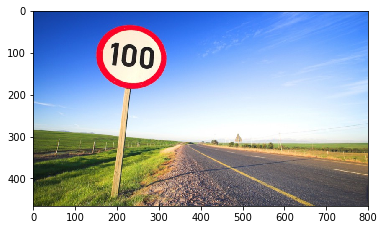

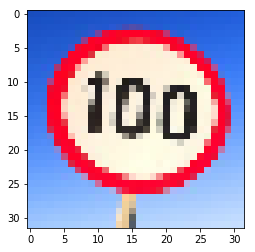

label=[Speed limit (30km/h)] id=1 conf=1.0
Draw label=[Speed limit (30km/h)] id=1 conf=1.0


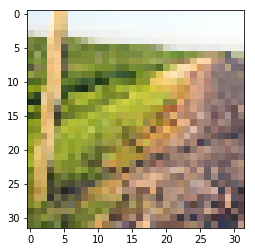

label=[Slippery road] id=23 conf=1.0
No 23: 1.00


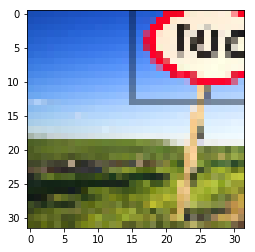

label=[End of no passing] id=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0


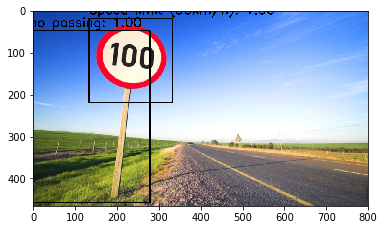

In [16]:
import os
import sys
import cv2
#brew install opencv
#pip install opencv-python
import numpy as np
from pandas import read_csv
#pip install moviepy
#pip install requests
from moviepy.editor import *
from matplotlib import pyplot as plt 
import keras
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import tensorflow as tf


infile="../picture/v.mp4"
outfile="../picture/v-output.mp4"

'''
Code adapted from:
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

'''

IMG_SHAPE=[32,32,3]
INPUT_SHAPE=[1,32,32,3]
L2_LAMBDA = 0.0001   
WEIGTHS_PATH="../doc/weights_mltscl_dataaug.hdf5"
OUTPUT_DIM=43
LR = 0.0001
CONF_THRES=0.5

# Labels of circlur signs
cir_cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16,
           17, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

signnames = read_csv("../doc/signnames.csv").values[:, 1]

print(signnames)

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    Ref: https://stackoverflow.com/questions/34968722/softmax-function-python
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def build_mltscl():
    """
    Build multiscale CNN. The last layer must be logits instead of softmax.
    Return a compiled Keras model.
    """

    # Regularization
    l2_reg = keras.regularizers.l2(L2_LAMBDA)

    # Build model
    inpt = keras.layers.Input(shape=IMG_SHAPE)
    conv1 = keras.layers.Convolution2D(
        32, (5, 5), padding='same', activation='relu')(inpt)
    drop1 = keras.layers.Dropout(rate=0.1)(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop1)

    conv2 = keras.layers.Convolution2D(
        64, (5, 5), padding='same', activation='relu')(pool1)
    drop2 = keras.layers.Dropout(rate=0.2)(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop2)

    conv3 = keras.layers.Convolution2D(
        128, (5, 5), padding='same', activation='relu')(pool2)
    drop3 = keras.layers.Dropout(rate=0.3)(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop3)

    pool4 = keras.layers.MaxPooling2D(pool_size=(4, 4))(pool1)
    pool5 = keras.layers.MaxPooling2D(pool_size=(2, 2))(pool2)

    flat1 = keras.layers.Flatten()(pool4)
    flat2 = keras.layers.Flatten()(pool5)
    flat3 = keras.layers.Flatten()(pool3)

    merge = keras.layers.Concatenate(axis=-1)([flat1, flat2, flat3])
    dense1 = keras.layers.Dense(1024, activation='relu',
                                kernel_regularizer=l2_reg)(merge)
    drop4 = keras.layers.Dropout(rate=0.5)(dense1)
    output = keras.layers.Dense(
        OUTPUT_DIM, activation=None, kernel_regularizer=l2_reg)(drop4)
    model = keras.models.Model(inputs=inpt, outputs=output)

    # Specify optimizer
    adam = keras.optimizers.Adam(
        lr=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

model=build_mltscl()
model.load_weights(WEIGTHS_PATH)
#model.summary()

def rgb2gray(image):
    """Convert 3-channel RGB image into grayscale"""
    if image.ndim == 3:
        return (0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] +
                0.114 * image[:, :, 2])
    elif image.ndim == 4:
        return (0.299 * image[:, :, :, 0] + 0.587 * image[:, :, :, 1] +
                0.114 * image[:, :, :, 2])

#识别原型的交通牌
def find_circles(img, mg_ratio=0.4, n_circles=1):
    """
    Find circular objects and return bounding boxes in the format
    [x1, y1, x2, y2]
    """

    targetImg = np.copy(img)
    targetImg = np.uint8(targetImg * 255)
    # Apply Gaussian blur if needed
    n = 13
    targetImg = cv2.GaussianBlur(targetImg, (n, n), 0)

    # Convert to grayscale
    grayImg = np.uint8(rgb2gray(targetImg))
    #grayImg = targetImg
    # param1 is canny threshold, param2 is circle accumulator threshold
    # Set of parameters for GTSDB testing
    # (because of different frame size and recording device)
    # circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
    #                            param1=60, param2=50, minRadius=5,
    #                            maxRadius=100)
    circles = cv2.HoughCircles(grayImg, cv2.HOUGH_GRADIENT, 1, 200,
                               param1=50, param2=30, minRadius=20,
                               maxRadius=250)

    bboxes = []
    try:
        cir = circles.astype(np.uint16)
        for c in cir[0, :n_circles]:
            r = int(c[2])
            mg = int(r * mg_ratio)
            bboxes.append([c[0] - r - mg, c[1] - r - mg,
                           c[0] + r + mg, c[1] + r + mg])
    except AttributeError:
        pass
    except:
        raise
    return bboxes


def draw_bb(img, bbox, color=(0, 1, 0)):
    """Draw bounding box"""
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]),
                  color, 2)
    return img

def crop_bb(img, bbox):
    """Crop image by specifying bounding box"""
    bb = np.array(bbox)
    bb = bb * (bb > 0)
    return img[bb[1]:bb[3], bb[0]:bb[2], :]


def demo():
    
    demo_file="../picture/traffic_sign.jpeg"
    #OpenCV读取的格式为BGR 需要转换成RGB进行展现
    demo_img=cv2.imread(demo_file)
    demo_img = cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB) 
    show_img=demo_img.copy()
    plt.imshow(show_img) 
    plt.show() 
        
    bboxes = find_circles(show_img.copy(), mg_ratio=0.4, n_circles=3)
    for bbox in bboxes:
        crop = crop_bb(show_img, bbox)
        #resized_im = resize(crop)
        resized_im=cv2.resize(crop,(32,32))
        
        plt.imshow(resized_im) 
        plt.show() 
        
        resized_im=resized_im.reshape(INPUT_SHAPE)
        #resized_im =np.expand_dims(resized_im, axis=0)
        #label = signnames[predict(model, resized_im)]
        label = np.argmax(model.predict(resized_im)[0])
        conf = np.max(softmax(model.predict(resized_im)[0]))
        # Consider detection only if confidence is larger than threshold
        print("label=[{}] id={} conf={}".format(signnames[label],label,conf))
        if (conf > CONF_THRES ) and  (label in cir_cls) :
            print("Draw label=[{}] id={} conf={}".format(signnames[label],label,conf))
            show_img = draw_bb(show_img, bbox)
            # Put label and confidence
            cv2.putText(show_img, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
        else:
            print('No {}: {:.2f}'.format(label, conf))

    
    plt.imshow(show_img) 
    plt.show() 
demo()


In [6]:
#全局计数器
count=0

#实现回调函数 处理每一帧图像
def invert_VideoFileClip(image):
    global count
    count=count+1
    #仅处理一部分 提高效率
    if count % 10 == 0 :
       
        bboxes = find_circles(image, mg_ratio=0.4, n_circles=3)
        for bbox in bboxes:
            crop = crop_bb(image, bbox)
            #resized_im = resize(crop)
            resized_im=cv2.resize(crop,(32,32))
            resized_im = np.expand_dims(resized_im, axis=0)
            #label = signnames[predict(model, resized_im)]
            logit=softmax(model.predict([resized_im])[0])
            #print(logit)
            label = np.argmax(logit)
            print(logit)
            conf = logit[label]
            # Consider detection only if confidence is larger than threshold
            print("label={} conf={}".format(label,conf))
            if (conf > CONF_THRES ) and  (label in cir_cls) :
                print("Draw label=[{}] id={} conf={}".format(signnames[label],label,conf))
                img = draw_bb(image, bbox)
                # Put label and confidence
                cv2.putText(image, '{}: {:.2f}'.format(signnames[label], conf), (bbox[0], bbox[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 1, 0), 2)
            else:
                print('Fail {}: {:.2f}'.format(label, conf))
    
    return image

clip = VideoFileClip(infile)
modifiedClip = clip.fl_image(invert_VideoFileClip)
modifiedClip.write_videofile(outfile)

[MoviePy] >>>> Building video ../picture/v-output.mp4
[MoviePy] Writing audio in v-outputTEMP_MPY_wvf_snd.mp3


100%|██████████| 314/314 [00:00<00:00, 396.44it/s]


[MoviePy] Done.
[MoviePy] Writing video ../picture/v-output.mp4


  2%|▏         | 9/426 [00:00<00:23, 18.06it/s]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 3.308327e-28 0.000000e+00]
label=34 conf=1.0
Draw label=[Turn left ahead] id=34 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
label=39 conf=1.0
Draw label=[Keep left] id=39 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
label=34 conf=1.0
Draw label=[Turn left ahead] id

  4%|▍         | 19/426 [00:00<00:20, 19.70it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
label=40 conf=1.0
Draw label=[Roundabout mandatory] id=40 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.5349407e-05 6.4020695e-30
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 9.9995470e-01 0.0000000e+00]
label=41 conf=0.9999547004699707
Draw label=[End of no passing] id=41 conf=0.9999547004699707
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

  7%|▋         | 29/426 [00:01<00:19, 20.76it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.4138367e-35 1.6155021e-28 0.0000000e+00]
label=33 conf=1.0
Draw label=[Turn right ahead] id=33 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0

  9%|▉         | 39/426 [00:01<00:17, 22.66it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.1849377e-13
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label=33 conf=1.0
Draw label=[Turn right ahead] id=33 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0

 12%|█▏        | 49/426 [00:02<00:17, 21.88it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.5022765e-09 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.1660935e-39 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.5032462e-44 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.7961606e-11 0.0000000e+00]
label=29 conf=1.0
Fail 29: 1.00
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.2808569e-28
 0.0000000e+00 0.0000000e+00 3.9689749e-10 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.9382326e-39 0.0000000e+00 0.0000000e+00
 

 15%|█▌        | 65/426 [00:02<00:15, 23.89it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.1654736e-04
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.9978346e-01 0.0000000e+00 0.0000000e+00]
label=40 conf=0.999783456325531
Draw label=[Roundabout mandatory] id=40 conf=0.999783456325531
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0369391e-24 0.0000000e+00 0.0000000e+00
 0.000000

 18%|█▊        | 76/426 [00:03<00:18, 19.38it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.2531703e-24 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.3563377e-16 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2061122e-35
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label=17 conf=1.0
Draw label=[No entry] id=17 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000

 19%|█▉        | 80/426 [00:03<00:23, 14.57it/s]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 9.017878e-34]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+

 22%|██▏       | 95/426 [00:04<00:17, 19.34it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.9600422e-18 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5134023e-43 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 2.9180430e-34 0.0000000e+00]
label=39 conf=1.0
Draw label=[Keep left] id=39 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.000

 25%|██▍       | 106/426 [00:05<00:17, 18.78it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.6517228e-10 0.0000000e+00 1.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label=38 conf=1.0
Draw label=[Keep right] id=38 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.00000

 27%|██▋       | 115/426 [00:05<00:17, 17.36it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 3.922024e-37]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 

 30%|██▉       | 126/426 [00:06<00:17, 17.43it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.3624734e-20 5.2108394e-06
 0.0000000e+00 0.0000000e+00 6.0950878e-41 4.7828559e-40 9.9999475e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label=39 conf=0.9999947547912598
Draw label=[Keep left] id=39 conf=0.9999947547912598
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.0461655e-38
 0.0000000e+00 0.0

 32%|███▏      | 135/426 [00:06<00:16, 17.60it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 8.1689905e-38 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.4929499e-41 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 5.3801192e-19 0.0000000e+00]
label=39 conf=1.0
Draw label=[Keep left] id=39 conf=1.0
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0

 35%|███▍      | 147/426 [00:07<00:14, 18.61it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.9393186e-16 9.1218782e-23
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.9987578e-01 1.2420487e-04 0.0000000e+00]
label=40 conf=0.9998757839202881
Draw label=[Roundabout mandatory] id=40 conf=0.9998757839202881
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 

 37%|███▋      | 156/426 [00:07<00:14, 19.06it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
label=40 conf=1.0
Draw label=[Roundabout mandatory] id=40 conf=1.0
[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 3.01662e-40
 1.00000e+00]
label=42 conf=1.0
Draw label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
label=22 conf=1.0
Fail 22: 1.00


 39%|███▊      | 165/426 [00:08<00:13, 19.37it/s]

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01347848 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.9865216 ]
label=42 conf=0.9865216016769409
Draw label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=0.9865216016769409
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+0

 41%|████▏     | 176/426 [00:08<00:12, 19.64it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 1.1783338e-21
 0.0000000e+00 9.8639278e-20 0.0000000e+00]
label=38 conf=1.0
Draw label=[Keep right] id=38 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.1455511e-29 0.0000000e+00 0.0000000e+00 7.1598413e-33
 0.0000000e+00 0.0000000e+00 2.8972667e-25 0.0000000e+00 0.0000000e+00
 0.0000000e+00 9.4734192e-34 1.6335893e-28 2.00

 44%|████▎     | 186/426 [00:09<00:12, 19.94it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 9.9985397e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.4596901e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label=11 conf=0.9998539686203003
Fail 11: 1.00
[5.6376541e-25 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 1.1363257e-30 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.4254915e-12 0.0000000e+00 

 46%|████▌     | 196/426 [00:09<00:11, 19.64it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
label=40 conf=1.0
Draw label=[Roundabout mandatory] id=40 conf=1.0
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 9.99897480e-01 1.02499835e-04]
label=41 conf=0.9998974800109863
Draw label=[End of no passing] id=41 conf=0.9998974800109863
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.00000

 48%|████▊     | 206/426 [00:10<00:10, 20.87it/s]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 1.252186e-40 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 9.474670e-17 3.528502e-12
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 0.000000e+00]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
label=42 conf=1.0
Draw label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
label=

 50%|█████     | 215/426 [00:10<00:10, 20.23it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 2.7911486e-26]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.7786177e-39 0.0000000e+00 0.0000000e+00 1.8602251e-39
 1.7987139e-22 0.0000000e+00 2.4318160e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 6.7842504e-

 53%|█████▎    | 226/426 [00:11<00:09, 21.08it/s]

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.48872345e-35 2.90068782e-43 0.00000000e+00
 0.00000000e+00 2.87619558e-31 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.80259693e-44 1.05474196e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.42431436e-16 1.00000000e+00
 0.00000000e+00 8.07553580e-10 0.00000000e+00]
label=39 conf=1.0
Draw label=[Keep left] id=39 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
label=39 conf=1.0
Draw label=[Keep left] id=39 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00

 55%|█████▌    | 235/426 [00:11<00:09, 19.43it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
label=42 conf=1.0
Draw label=[End of no passing by vechiles over 3.5 metric tons] id=42 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3659501e-25
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 3.9898474e-26 0.0000000e+00]
label=17 conf=1.0
Draw label=[No entry] id=17 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

 58%|█████▊    | 247/426 [00:12<00:09, 19.34it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6628166e-18 5.6158390e-20
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e

 60%|█████▉    | 254/426 [00:12<00:09, 18.73it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.3954386e-34
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.6319680e-29 3.2229865e-44
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5710997e-35 0.0000000e+00]
label=17 conf=1.0
Draw label=[No entry] id=17 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000

 62%|██████▏   | 265/426 [00:13<00:07, 21.46it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00 2.3410938e-19
 0.0000000e+00 3.4655302e-39 2.1019477e-43 0.0000000e+00 0.0000000e+00
 8.5966858e-41 0.0000000e+00 0.0000000e+00]
label=33 conf=1.0
Draw label=[Turn right ahead] id=33 conf=1.0
[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000

 65%|██████▍   | 276/426 [00:13<00:07, 21.14it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.8632231e-17
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.5931362e-41 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.4943113e-43 2.4774218e-16
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.9344820e-15 0.0000000e+00]
label=17 conf=1.0
Draw label=[No entry] id=17 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1529926e-19 0.0000000e+00 0.0000000e+00 9.7808254e-01
 0.0000000e+00 0.0000000e+00 8.8772258e-42 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.1917485e-02 0.0000

 67%|██████▋   | 285/426 [00:14<00:06, 20.14it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 7.3636265e-28
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00]
label=22 conf=1.0
Fail 22: 1.00
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.6345237e-39
 0.0000000e+00 0.0000000e+00 1.3632342e-23 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 

 69%|██████▉   | 295/426 [00:14<00:06, 19.84it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.0614325e-13
 0.0000000e+00 0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.8168212e-38 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.4811538e-19 8.1939582e-38]
label=17 conf=1.0
Draw label=[No entry] id=17 conf=1.0
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.5653e-41
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+0

 72%|███████▏  | 306/426 [00:15<00:06, 18.96it/s]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 2.675442e-32
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 0.000000e+00]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+

 74%|███████▍  | 315/426 [00:15<00:05, 20.05it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.6198400e-16 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.8313724e-35 0.0000000e+00]
label=34 conf=1.0
Draw label=[Turn left ahead] id=34 conf=1.0
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00736008 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.      

 76%|███████▋  | 325/426 [00:16<00:05, 19.55it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3522873e-12 1.2193141e-14
 0.0000000e+00 1.9127554e-14 0.0000000e+00 1.6369317e-17 7.1645789e-10
 0.0000000e+00 1.0000000e+00 2.9173736e-20]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

 79%|███████▉  | 336/426 [00:16<00:04, 19.86it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0499842e-35 3.5600565e-28
 0.0000000e+00 5.8586593e-39 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 0.0000000e+00 0.0000000e+00]
label=40 conf=1.0
Draw label=[Roundabout mandatory] id=40 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.000000

 81%|████████  | 345/426 [00:17<00:04, 19.47it/s]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 7.795623e-22 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 6.350105e-25 1.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00]
label=34 conf=1.0
Draw label=[Turn left ahead] id=34 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00

 83%|████████▎ | 354/426 [00:17<00:03, 22.65it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.6013277e-23 0.0000000e+00 0.0000000e+00 1.4969681e-02
 0.0000000e+00 0.0000000e+00 9.8503035e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.7879121e-28 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.5939484e-29 1.1210388e-44
 0.0000000e+00 4.0298334e-26 0.0000000e+00 0.0000000e+00 9.2332031e-29
 0.0000000e+00 1.5996974e-38 0.0000000e+00]
label=17 conf=0.9850303530693054
Draw label=[No entry] id=17 conf=0.9850303530693054
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.5456492e-18 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.00

 86%|████████▌ | 365/426 [00:18<00:02, 23.21it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
label=36 conf=1.0
Draw label=[Go straight or right] id=36 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.0000000e+00 1.8651346e-22 0.0000000e+00]
label=40 conf=1.0
Draw label=[Roundabout mandatory] id=40 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.000000

 88%|████████▊ | 375/426 [00:18<00:02, 20.36it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
label=13 conf=1.0
Fail 13: 1.00
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0


 91%|█████████ | 386/426 [00:19<00:02, 18.24it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 2.1884787e-38 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

 93%|█████████▎| 395/426 [00:19<00:01, 16.33it/s]

[0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 4.925085e-22 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 1.877740e-43 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 1.000000e+00 0.000000e+00]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.2953220e-34 0.0000000e+00 0.0000000e+00 4.8850689e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 9.0238192e-27 0.0000000e+00 0.0000000e+00
 0.0000000e+

 94%|█████████▎| 399/426 [00:20<00:02, 11.51it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 8.7552599e-37 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.3843436e-05 0.0000000e+00 7.3645105e-16 9.9994612e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.9453873e-14 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9535754e-39
 0.0000000e+00 9.9647735e-41 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 2.3573849e-19 0.0000000e+00 1.2453629e-18 1.3283122e-36
 0.0000000e+00 3.3631163e-44 0.0000000e+00]
label=14 conf=0.999946117401123
Fail 14: 1.00
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0

 98%|█████████▊| 416/426 [00:21<00:00, 17.28it/s]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
label=40 conf=1.0
Draw label=[Roundabout mandatory] id=40 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0466074e-25 0.000000

100%|██████████| 426/426 [00:21<00:00, 19.73it/s]

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.3461959e-35 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.2415923e-12 0.0000000e+00 8.7781470e-35
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7612790e-37
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0000000e+00 0.0000000e+00]
label=41 conf=1.0
Draw label=[End of no passing] id=41 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
label=39 conf=1.0
Draw label=[Keep left] id=39 conf=1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
labe

[MoviePy] Done.
[MoviePy] >>>> Video ready: ../picture/v-output.mp4 

